In [137]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../code/')
import leakage
import FBA_leak
import reframed
import gurobipy as gp
from reframed.solvers.solution import Solution, Status
import time
from collections import defaultdict
import re

In [159]:
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

In [160]:
# model.reactions.DHAPT.knock_out()
# model.reactions.THRA.knock_out()
# model.reactions.THRA2.knock_out()
# model.reactions.F6PA_TG_forward.knock_out()

In [161]:
model.reactions.EX_glc__D_e.lower_bound = -5


In [163]:
print(model.optimize())
print(model.summary())

<Solution 0.484 at 0x2b6511650>
Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.48406639773307514

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00252         0   0.00%
      cl_e      EX_cl_e   0.00252         0   0.00%
 cobalt2_e EX_cobalt2_e  1.21E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0003432         0   0.00%
     fe2_e     EX_fe2_e  0.007775         0   0.00%
  glc__D_e  EX_glc__D_e         5         6 100.00%
       k_e       EX_k_e   0.09449         0   0.00%
     mg2_e     EX_mg2_e  0.004199         0   0.00%
     mn2_e     EX_mn2_e 0.0003345         0   0.00%
    mobd_e    EX_mobd_e 6.244E-05         0   0.00%
     nh4_e     EX_nh4_e     5.228         0   0.00%
     ni2_e     EX_ni2_e 0.0001564         0   0.00%
      o2_e      EX_o2_e     9.097         0   0.00%
      pi_e      EX_pi_e    0.4669         0   0.00%
     so4_e     EX_so4_e    0.1221         0   0.00%
  

In [578]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

In [579]:
solution = reframed.FBA(model)

In [580]:
print(solution)

Objective: 0.742975386519784
Status: Optimal



# Implementatation of FBA with leakage

In [119]:
# load model
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

In [120]:
for r_id in model.get_exchange_reactions():
    model.reactions[r_id].ub = 1000
    

In [114]:
psolution = reframed.pFBA(model, constraints={'R_EX_glc__D_e':-10}, obj_frac=1)
psolution.show_values('R_EX_*')

R_EX_ca2_e   -0.00511325
R_EX_cl_e    -0.00511325
R_EX_co2_e    19.6752
R_EX_cobalt2_e -2.45593e-05
R_EX_cu2_e   -0.000696502
R_EX_fe2_e   -0.0157779
R_EX_glc__D_e -10
R_EX_h_e      9.02626
R_EX_h2o_e    45.6194
R_EX_k_e     -0.191752
R_EX_meoh_e   1.96474e-06
R_EX_mg2_e   -0.00852208
R_EX_mn2_e   -0.000678819
R_EX_mobd_e  -0.000126726
R_EX_nh4_e   -10.6104
R_EX_ni2_e   -0.000317306
R_EX_o2_e    -17.5789
R_EX_pi_e    -0.947626
R_EX_so4_e   -0.247764
R_EX_zn2_e   -0.000334989


In [591]:
selected_metabolites = []
selected_metabolites_exchanges = []
for m_id, turnover in psolution.get_metabolites_turnover(model).items():
    if m_id.endswith('_c') and turnover > 1e-6:
        r_ex_id = f'R_EX_{m_id[2:-2]}_e'
        if r_ex_id in model.reactions:
            selected_metabolites.append(m_id)
            selected_metabolites_exchanges.append(r_ex_id)

        
        

In [592]:
solution = reframed.FBA(model, constraints={'R_EX_glc__D_e':-5}, shadow_prices=True)

In [593]:
predicted_log_leakage_rates = {}
slope = -1.94204311
intercept = -6.08989226
for m_id, r_ex_id in zip(selected_metabolites, selected_metabolites_exchanges):
    metabolite_value = - solution.shadow_prices[m_id]
    if np.isfinite(metabolite_value) and metabolite_value > 1e-7:
        # Use trendline from fit 
        lograte = intercept + slope*np.log10(metabolite_value)
        predicted_log_leakage_rates[r_ex_id] = lograte

In [595]:
solver = reframed.solver_instance(model)
log_vars = {}
for r_ex_id in selected_metabolites_exchanges:
    # r_ex_id = f'R_EX_{m_id[2:-2]}_e'
    r_ex = model.reactions[r_ex_id]
    r_ex.ub = 1000
    if r_ex.lb < 0:
        print(r_ex, r_ex.lb)
        continue
    # log_x = problem.addVar(vtype=gp.GRB.CONTINUOUS, name = f'log_{r_ex_id}', lb=-gp.GRB.INFINITY)
    solver.add_variable(var_id= f'log_{r_ex_id}', lb=-10, ub=10)
    x = solver.problem.getVarByName(r_ex_id)
    x.ub = 1000
    log_x = solver.problem.getVarByName(f'log_{r_ex_id}')
    log_vars[f'log_{r_ex_id}'] = log_x
    c = solver.problem.addGenConstrLogA(x, log_x, 10, name = f'logc_{r_ex_id}', options='FuncPieceError=1e-6 FuncPieces=-1')
    solver.constr_ids.append(f'logc_{r_ex_id}')
    # 
    # solver.add_constraint(constr_id='test', lhs={x.VarName:1, log_x.VarName:-1}, rhs = 0)
solver.problem.update()
solver.update()

R_EX_ca2_e: M_ca2_e <->  [-inf, 1000] -inf
R_EX_cl_e: M_cl_e <->  [-inf, 1000] -inf
R_EX_co2_e: M_co2_e <->  [-inf, 1000] -inf
R_EX_cobalt2_e: M_cobalt2_e <->  [-inf, 1000] -inf
R_EX_cu2_e: M_cu2_e <->  [-inf, 1000] -inf
R_EX_fe2_e: M_fe2_e <->  [-inf, 1000] -inf
R_EX_fe3_e: M_fe3_e <->  [-inf, 1000] -inf
R_EX_glc__D_e: M_glc__D_e <->  [-5, 1000] -5
R_EX_h_e: M_h_e <->  [-inf, 1000] -inf
R_EX_h2o_e: M_h2o_e <->  [-inf, 1000] -inf
R_EX_k_e: M_k_e <->  [-inf, 1000] -inf
R_EX_mg2_e: M_mg2_e <->  [-inf, 1000] -inf
R_EX_mn2_e: M_mn2_e <->  [-inf, 1000] -inf
R_EX_mobd_e: M_mobd_e <->  [-inf, 1000] -inf
R_EX_nh4_e: M_nh4_e <->  [-inf, 1000] -inf
R_EX_ni2_e: M_ni2_e <->  [-inf, 1000] -inf
R_EX_o2_e: M_o2_e <->  [-inf, 1000] -inf
R_EX_pi_e: M_pi_e <->  [-inf, 1000] -inf
R_EX_so4_e: M_so4_e <->  [-inf, 1000] -inf
R_EX_zn2_e: M_zn2_e <->  [-inf, 1000] -inf


In [596]:
# log_vars = {}
# for m_id, r_ex_id in zip(selected_metabolites, selected_metabolites_exchanges):
#     r_ex = model.reactions[r_ex_id]
#     if r_ex.lb <0:
#         # reaction lb has to be > 0 for LogA constraint to work
#         continue
#     log_x = problem.addVar(vtype=gp.GRB.CONTINUOUS, name = f'log_{r_ex_id}')
#     x = problem.getVarByName(r_ex_id)
#     log_vars[m_id] = log_x
#     problem.addGenConstrLogA(x, log_x, 10)

In [597]:
# Make linear objective
lin_obj = {}
for r_ex_id, lograte in predicted_log_leakage_rates.items():
    lin_obj[r_ex_id] = 2*lograte

In [599]:
# Make quadratic objective
quad_obj = {}
for key, _ in lin_obj.items():
    quad_obj.update({(key,key):1})

In [600]:
# Constraints
r_growth = model.biomass_reaction
min_growth = solution.values[r_growth]*0.9
constraints = {r_growth:(min_growth,1), 'R_EX_glc__D_e':-5}#, 'R_EX_glc__D_e': (-6, -3)}

In [601]:

solver.problem.params.BarHomogeneous = 1
solution = solver.solve(lin_obj, quadratic=quad_obj, minimize=True, constraints=constraints)
print(solution)
solution.show_values('R_EX_*')
solution.show_values(r_growth)

Objective: None
Status: Infeasible or Unbounded



In [140]:
# The (x-b)**2 objective is decomposed into a quadratic and a linear part
# Since (x-b)**2 = x**2 - 2*x*b+b**2 + b**2
lin_obj = {'R_EX_pyr_e':-2*2, 'R_EX_ac_e':-2*2, 'R_EX_lac__L_e':-2*2}

# solver = reframed.solver_instance(model)
quad_obj = {}
for key, _ in lin_obj.items():
    quad_obj.update({(key,key):1})
constraints = {r_growth:(0.2,1), 'R_EX_glc__D_e': -6,}
solver.problem.params.BarHomogeneous = 1
solution = solver.solve(lin_obj, quadratic=quad_obj, minimize=True, constraints=constraints)
print(solution)
solution.show_values('R_EX_*')
solution.show_values(r_growth)

Objective: None
Status: Infeasible



In [126]:
solution.values[

{'R_DM_4crsol_c': 0.00013027594076604914,
 'R_DM_5drib_c': 0.0001314443348536404,
 'R_DM_aacald_c': 0.0,
 'R_DM_amob_c': 1.1683940875878846e-06,
 'R_DM_mththf_c': 0.0002617202756196868,
 'R_DM_oxam_c': 0.0,
 'R_BIOMASS_Ec_iJO1366_WT_53p95M': 0.0,
 'R_BIOMASS_Ec_iJO1366_core_53p95M': 0.5841970437939423,
 'R_EX_12ppd__R_e': 0.0,
 'R_EX_12ppd__S_e': 0.0,
 'R_EX_14glucan_e': 0.0,
 'R_EX_15dap_e': 0.0,
 'R_EX_23camp_e': 0.0,
 'R_EX_23ccmp_e': 0.0,
 'R_EX_23cgmp_e': 0.0,
 'R_EX_23cump_e': 0.0,
 'R_EX_23dappa_e': 0.0,
 'R_EX_26dap__M_e': 0.0,
 'R_EX_2ddglcn_e': 0.0,
 'R_EX_34dhpac_e': 0.0,
 'R_EX_3amp_e': 0.0,
 'R_EX_3cmp_e': 0.0,
 'R_EX_3gmp_e': 0.0,
 'R_EX_3hcinnm_e': 0.0,
 'R_EX_3hpp_e': 0.0,
 'R_EX_3hpppn_e': 0.0,
 'R_EX_3ump_e': 0.0,
 'R_EX_4abut_e': 0.0,
 'R_EX_4hoxpacd_e': 0.0,
 'R_EX_5dglcn_e': 0.0,
 'R_EX_5mtr_e': 0.0,
 'R_EX_LalaDglu_e': 0.0,
 'R_EX_LalaDgluMdap_e': 0.0,
 'R_EX_LalaDgluMdapDala_e': 0.0,
 'R_EX_LalaLglu_e': 0.0,
 'R_EX_ac_e': 0.0,
 'R_EX_acac_e': 0.0,
 'R_EX_acald_e'

# Functional implementation

In [54]:
model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'
# model.reactions.R_EX_lac__L_e.ub = 1000
model.reactions.R_EX_glc__D_e.lb = -10
# model.update()
for r_id in model.get_exchange_reactions():
    model.reactions[r_id].ub = 1000

In [115]:
model.set_flux_bounds?

Signature: model.set_flux_bounds(r_id, lb=None, ub=None)
Docstring:
Define flux bounds for one reaction

Arguments:
    r_id (str): reaction id
    lb (float): lower bound
    ub (float): upper bound
File:      ~/anaconda3/lib/python3.11/site-packages/reframed/core/cbmodel.py
Type:      method

In [107]:
solution = reframed.FBA(model, constraints={'R_EX_glc__D_e': -6})

In [108]:
psolution = reframed.pFBA(model, constraints={'R_EX_glc__D_e': -6})

In [113]:
psolution.values[model.biomass_reaction]

'R_BIOMASS_Ec_iJO1366_core_53p95M'

In [56]:
selected_metabolites = []
selected_metabolites_exchanges = []
for m_id, turnover in solution.get_metabolites_turnover(model).items():#Should use parsimonious solutions
    if m_id.endswith('_c') and turnover > 1e-6:
        r_ex_id = f'R_EX_{m_id[2:-2]}_e'
        if r_ex_id in model.reactions:
            selected_metabolites.append(m_id)
            selected_metabolites_exchanges.append(r_ex_id)


In [57]:
fva_results = reframed.FVA(model, obj_frac=0.9, constraints={'R_EX_glc__D_e': -6}, reactions = selected_metabolites_exchanges)

In [58]:
leak_mets = []
leak_exchanges = []
for m_id, r_ex_id in zip(selected_metabolites, selected_metabolites_exchanges):
    lb, ub = fva_results[r_ex_id]
    if ub > 0:
        leak_mets.append(m_id)
        leak_exchanges.append(r_ex_id)


In [59]:
solution = reframed.FBA(model, constraints={'R_EX_glc__D_e': -6}, shadow_prices=True)
predicted_log_leakage_rates = {}
slope =  -3 #-1.94204311
intercept = -4 #-6.08989226
predicted_metabolite_values = {}
for m_id, r_ex_id in zip(leak_mets, leak_exchanges):
    metabolite_value = - solution.shadow_prices[m_id]
    if np.isfinite(metabolite_value) and metabolite_value > 1e-7:
        # Use trendline from fit 
        lograte = intercept + slope*np.log10(metabolite_value)
        predicted_log_leakage_rates[r_ex_id] = lograte
        predicted_metabolite_values[r_ex_id] = metabolite_value

In [100]:
# selected_mets = ['M_pyr_c', 'M_cit_c']
solver = reframed.solver_instance(model)
log_vars = []
for m_id in leak_mets:
    r_ex_id = f'R_EX_{m_id[2:-2]}_e'
    r_ex = model.reactions[r_ex_id]
    r_ex.ub = 1000
    if r_ex.lb < 0:
        print(r_ex, r_ex.lb)
        continue
    if not predicted_log_leakage_rates.get(r_ex_id):
        print(r_ex)
        continue
    # log_x = problem.addVar(vtype=gp.GRB.CONTINUOUS, name = f'log_{r_ex_id}', lb=-gp.GRB.INFINITY)
    solver.add_variable(var_id= f'log_{r_ex_id}', lb=-10, ub=10)
    x = solver.problem.getVarByName(r_ex_id)
    x.ub = 1000
    log_x = solver.problem.getVarByName(f'log_{r_ex_id}')
    log_vars.append(f'log_{r_ex_id}')
    c = solver.problem.addGenConstrLogA(x, log_x, 10, name = f'logc_{r_ex_id}', options='FuncPieceError=1e-5 FuncPieces=-2')
    solver.constr_ids.append(f'logc_{r_ex_id}')
    # 
    # solver.add_constraint(constr_id='test', lhs={x.VarName:1, log_x.VarName:-1}, rhs = 0)
solver.problem.update()
solver.update()

R_EX_co2_e: M_co2_e <->  [-inf, 1000] -inf
R_EX_fe2_e: M_fe2_e <->  [-inf, 1000] -inf
R_EX_fe3_e: M_fe3_e <->  [-inf, 1000] -inf
R_EX_h_e: M_h_e <->  [-inf, 1000] -inf
R_EX_h2o_e: M_h2o_e <->  [-inf, 1000] -inf
R_EX_meoh_e: M_meoh_e -->  [0.0, 1000]


In [157]:
r = reframed.Reaction?

Init signature:
reframed.Reaction(
    reaction_id,
    name=None,
    reversible=True,
    stoichiometry=None,
    regulators=None,
    reaction_type=None,
)
Docstring:      Base class for modeling reactions. 
Init docstring:
Arguments:
    reaction_id (str): a valid unique identifier
    name (str): common reaction name
    reversible (bool): reaction reversibility (default: True)
    stoichiometry (dict): stoichiometry
    regulators (dict): reaction regulators
    reaction_type (ReactionType): reaction type
File:           ~/anaconda3/lib/python3.11/site-packages/reframed/core/model.py
Type:           type
Subclasses:     CBReaction

In [154]:
r = model.reactions.R_MCTP1App

In [163]:
np.random.normal(0, 1)

-0.9699947559923658

In [97]:
for r_id in log_vars:
    print(r_id, r_id in solver.var_ids)

log_R_EX_ac_e True
log_R_EX_acser_e True
log_R_EX_ade_e True
log_R_EX_akg_e True
log_R_EX_ala__D_e True
log_R_EX_ala__L_e True
log_R_EX_alaala_e True
log_R_EX_arg__L_e True
log_R_EX_asn__L_e True
log_R_EX_asp__L_e True
log_R_EX_cit_e True
log_R_EX_cys__L_e True
log_R_EX_for_e True
log_R_EX_glu__L_e True
log_R_EX_gly_e True
log_R_EX_glyc3p_e True
log_R_EX_glyclt_e True
log_R_EX_h2s_e True
log_R_EX_his__L_e True
log_R_EX_hom__L_e True
log_R_EX_ile__L_e True
log_R_EX_indole_e True
log_R_EX_kdo2lipid4_e True
log_R_EX_leu__L_e True
log_R_EX_lys__L_e True
log_R_EX_mal__L_e True
log_R_EX_meoh_e True
log_R_EX_orn_e True
log_R_EX_phe__L_e True
log_R_EX_pheme_e True
log_R_EX_pro__L_e True
log_R_EX_pyr_e True
log_R_EX_ser__L_e True
log_R_EX_succ_e True
log_R_EX_thr__L_e True
log_R_EX_trp__L_e True
log_R_EX_tyr__L_e True
log_R_EX_val__L_e True


In [141]:
for m_id in leak_mets:
    m = model.metabolites[m_id]
    element_dict = get_element_dict(m)
    if not element_dict or element_dict['C'] == 0:
        print(m_id)
    elif m_id in ['M_co2_c', 'M_hco3_c']:
        print(m_id)

M_co2_c
M_fe2_c
M_fe3_c
M_h_c
M_h2o_c
M_h2s_c


In [138]:
get_element_dict(m)

defaultdict(int, {'C': 2, 'H': 3, 'O': 2})

In [142]:
model2 = model.copy()


In [146]:
for r_id in leak_exchanges:
    model.set_flux_bounds(r_id, ub = 1000)

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/cbmodel.py:354: UserWarning: Reaction R_EX_co2_e not found
  warn(f"Reaction {r_id} not found")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/cbmodel.py:354: UserWarning: Reaction R_EX_fe2_e not found
  warn(f"Reaction {r_id} not found")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/cbmodel.py:354: UserWarning: Reaction R_EX_fe3_e not found
  warn(f"Reaction {r_id} not found")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/cbmodel.py:354: UserWarning: Reaction R_EX_h_e not found
  warn(f"Reaction {r_id} not found")
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/reframed/core/cbmodel.py:354: UserWarning: Reaction R_EX_h2o_e not found
  warn(f"Reaction {r_id} not found")


In [147]:
reframed.core.transformation.make_irreversible(model, reactions = leak_exchanges)

{}

In [104]:
# The (x-b)**2 objective is decomposed into a quadratic and a linear part
# Since (x-b)**2 = x**2 - 2*x*b+b**2 + b**2
# lin_obj = {'R_EX_pyr_e': -2*0.4}
t0 = time.time()
r_growth = model.biomass_reaction
lin_obj = {}
for log_name in log_vars:
    r_ex_id = log_name[4:]
    lin_obj[log_name] = -2*predicted_log_leakage_rates[r_ex_id]
    
# solver = reframed.solver_instance(model)
quad_obj = {}
for key, _ in lin_obj.items():
    quad_obj.update({(key,key):1})
# quad_obj = None

constraints = {r_growth:(solution.fobj*0.9,1), 'R_EX_glc__D_e': -6}
solver.problem.params.BarHomogeneous = 1
solution = solver.solve(lin_obj, quadratic=quad_obj, minimize=True, constraints=constraints, get_values=True)
print(solution)
solution.show_values('R_EX_')
solution.show_values(r_growth)
print(time.time()-t0)

Objective: -65.92123393246072
Status: Optimal

R_EX_ac_e     1.30411
R_EX_acser_e  0.151511
R_EX_ade_e    0.112777
R_EX_akg_e    0.201109
R_EX_ala__D_e  0.374448
R_EX_ala__L_e  0.437621
R_EX_alaala_e  0.0719741
R_EX_arg__L_e  0.058
R_EX_asn__L_e  0.296103
R_EX_asp__L_e  0.349539
R_EX_cit_e    0.146976
R_EX_co2_e   -3.99433
R_EX_cys__L_e  0.0907743
R_EX_fe2_e   -0.000927639
R_EX_for_e    10.415
R_EX_glc__D_e -6
R_EX_glu__L_e  0.153049
R_EX_gly_e    1.34709
R_EX_glyc3p_e  0.211757
R_EX_glyclt_e  1.58365
R_EX_h_e      21.2684
R_EX_h2o_e    6.33104
R_EX_h2s_e    0.508974
R_EX_his__L_e  0.0576124
R_EX_hom__L_e  0.167747
R_EX_ile__L_e  0.0368542
R_EX_indole_e  0.0176134
R_EX_kdo2lipid4_e  0.00075449
R_EX_leu__L_e  0.0490347
R_EX_lys__L_e  0.0437816
R_EX_mal__L_e  0.361405
R_EX_nh4_e   -6.00277
R_EX_o2_e    -3.68942
R_EX_orn_e    0.077
R_EX_phe__L_e  0.016148
R_EX_pheme_e  0.000927639
R_EX_pi_e    -0.213266
R_EX_pro__L_e  0.086
R_EX_pyr_e    0.654921
R_EX_ser__L_e  0.499893
R_EX_so4_e   -0.59

In [105]:
x_arr = []
y_arr = []
for log_name in log_vars:
    r_ex_id = log_name[4:]
    x_arr.append(predicted_metabolite_values[r_ex_id])
    y_arr.append(solution.values[r_ex_id])
    # print(r_ex_id, np.round(predicted_log_leakage_rates[r_ex_id],2), np.round(solution.values[log_name],2), np.round(np.log10(solution.values[r_ex_id]),2))

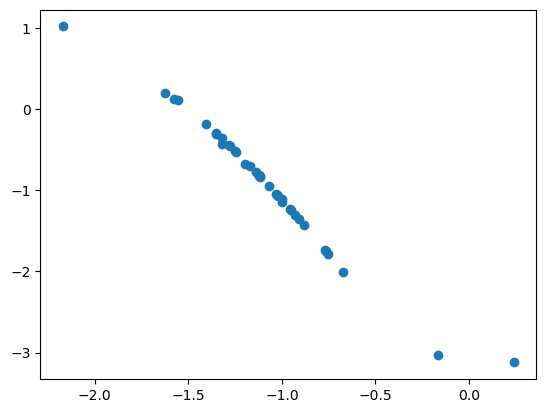

In [106]:
plt.scatter(np.log10(x_arr), np.log10(y_arr))

In [449]:
solver.set_objective(linear=lin_obj, quadratic=quad_obj)

In [450]:
solver.problem.optimize()

In [451]:
status = reframed.solvers.gurobi_solver.status_mapping.get(problem.status, Status.UNKNOWN)
message = str(problem.status)

In [452]:
status

<Status.INFEASIBLE: 'Infeasible'>

In [402]:
values = {r_id: solver.problem.getVarByName(r_id).X for r_id in solver.var_ids}

In [404]:
values['log_R_EX_pyr_e']

0.4

In [403]:
values['R_EX_pyr_e']

2.5494524563478387

In [133]:

def get_element_dict(metabolite):
    try:
        formula = metabolite.metadata['FORMULA']
    except KeyError:
        return np.nan
    else:
        element_count = extract_elements_and_counts(formula)
        return element_count


def extract_elements_and_counts(formula):
    element_pattern = r'([A-Z][a-z]*)(\d*)'
    # element_pattern = r'([A-Z][a-z]*)(\d*)'
    elements = re.findall(element_pattern, formula)
    element_count = defaultdict(int)
    
    current_element = ''
    for element, count in elements:
        if element.isalpha():
            element_count[element] += int(count) if count else 1
    
    return element_count

In [125]:
next(iter(model.reactions.R_EX_15dap_e.stoichiometry))

'M_15dap_e'

In [278]:
x = problem.getVarByName(r_ex_id)

AttributeError: Unable to retrieve attribute 'X'

In [200]:
solution.show_values('log*')

In [596]:
# The (x-b)**2 objective is decomposed into a quadratic and a linear part
# Since (x-b)**2 = x**2 - 2*x*b+b**2 + b**2
rxns = 
lin_obj = {'R_EX_pyr_e':-2*1, 'R_EX_ac_e':-2*2, 'R_EX_lac__L_e':-2*2}
solver = reframed.solver_instance(model)
quad_obj = {}
for key, _ in lin_obj.items():
    quad_obj.update({(key,key):1})
constraints = {r_growth:(0.2,1)}#, 'R_EX_glc__D_e': (-6, -3)}
solver.problem.params.BarHomogeneous = 1
solution = solver.solve(lin_obj, quadratic=quad_obj, minimize=True, constraints=constraints)
print(solution)
solution.show_values('R_EX_*')
solution.show_values(r_growth)

Objective: -9.0
Status: Optimal

R_EX_ac_e     2
R_EX_ca2_e   -0.00104235
R_EX_cl_e    -0.00104235
R_EX_co2_e    8.63122
R_EX_cobalt2_e -5.00646e-06
R_EX_cu2_e   -0.000141983
R_EX_etoh_e   0.00751361
R_EX_fe2_e   -2.76194
R_EX_fe3_e    2.75872
R_EX_for_e    0.0477064
R_EX_glc__D_e -4.99682
R_EX_h_e      4.148
R_EX_h2o_e    16.2973
R_EX_k_e     -0.039089
R_EX_lac__D_e  0.00805529
R_EX_lac__L_e  2
R_EX_meoh_e   4.00517e-07
R_EX_mg2_e   -0.00173724
R_EX_mn2_e   -0.000138379
R_EX_mobd_e  -2.58333e-05
R_EX_nh4_e   -2.16296
R_EX_ni2_e   -6.46835e-05
R_EX_o2_e    -9.41262
R_EX_pi_e    -0.193175
R_EX_pyr_e    1
R_EX_so4_e   -0.0505072
R_EX_succ_e   0.00547066
R_EX_zn2_e   -6.82881e-05
R_BIOMASS_Ec_iJO1366_core_53p95M  0.200258


In [590]:
problem = solver.problem

if constraints:
    old_constraints = {}
    for r_id, x in constraints.items():
        lb, ub = x if isinstance(x, tuple) else (x, x)
        if r_id in solver.var_ids:
            lpvar = problem.getVarByName(r_id)
            old_constraints[r_id] = (lpvar.lb, lpvar.ub)
            lpvar.lb = infinity_fix(lb)
            lpvar.ub = infinity_fix(ub)
        else:
            print(f"Constrained variable '{r_id}' not previously declared")
    problem.update()

In [591]:
solver.set_objective(lin_obj, quad_obj, minimize=True)

In [592]:

solver.problem.params.FeasibilityTol = 1e-7
solver.problem.params.OptimalityTol = 1e-7
solver.problem.params.TimeLimit = 120
solver.problem.params.NumericFocus = 3

solver.problem.params.BarHomogeneous = 1

solver.update()

-1

In [593]:
problem.optimize()

status = status_mapping.get(problem.status, Status.UNKNOWN)
message = str(problem.status)
values = {r_id: problem.getVarByName(r_id).X for r_id in solver.var_ids}
print(status, message)
print(problem.ObjVal)

Status.OPTIMAL 2
-8.999999999999998


In [594]:
solution = Solution(status, message, problem.ObjVal, values)

In [595]:
solution.show_values('R_EX_*')
solution.show_values(r_growth)

R_EX_ac_e     2
R_EX_ca2_e   -0.0010426
R_EX_cl_e    -0.0010426
R_EX_co2_e    8.63712
R_EX_cobalt2_e -5.00767e-06
R_EX_cu2_e   -0.000142017
R_EX_etoh_e   0.00743994
R_EX_fe2_e   -2.67309
R_EX_fe3_e    2.66987
R_EX_for_e    0.0398287
R_EX_glc__D_e -4.99558
R_EX_h_e      4.22897
R_EX_h2o_e    16.26
R_EX_k_e     -0.0390984
R_EX_lac__D_e  0.00777437
R_EX_lac__L_e  2
R_EX_meoh_e   4.00614e-07
R_EX_mg2_e   -0.00173766
R_EX_mn2_e   -0.000138412
R_EX_mobd_e  -2.58396e-05
R_EX_nh4_e   -2.16348
R_EX_ni2_e   -6.4699e-05
R_EX_o2_e    -9.3923
R_EX_pi_e    -0.193222
R_EX_pyr_e    1
R_EX_so4_e   -0.0505193
R_EX_succ_e   0.00538721
R_EX_zn2_e   -6.83046e-05
R_BIOMASS_Ec_iJO1366_core_53p95M  0.200307


In [ ]:
reframed.

In [505]:
from math import inf
from reframed.solvers.solution import Status, Solution
# from reframed.solution import Solution, Status
from gurobipy import Model as GurobiModel, GRB, quicksum

def infinity_fix(val):
    if val == inf:
        return GRB.INFINITY
    elif val == -inf:
        return -GRB.INFINITY
    else:
        return val

status_mapping = {
    GRB.OPTIMAL: Status.OPTIMAL,
    GRB.UNBOUNDED: Status.UNBOUNDED,
    GRB.INFEASIBLE: Status.INFEASIBLE,
    GRB.INF_OR_UNBD: Status.INF_OR_UNB
}


In [196]:
var = solver.problem.getVarByName(r_ex_id)

In [197]:
solver.solve({r_ex_id

<gurobi.Var R_EX_pyr_e>

In [199]:
r_ex_id = 'R_EX_pyr_e'
r = model.reactions[r_ex_id]
r.ub = 1000
# constraint.append((var-3)**2)
problem.setObjective(var, gp.GRB.MINIMIZE)
# solver.problem.se

GurobiError: Variable not in model

# FBA with leakage

In [31]:
shadow_prices = leakage.estimate_shadow_prices(model)

In [32]:
predicted_log_leakage_rates = {}
slope = -1.94204311
intercept = -6.08989226
for key, value in shadow_prices.items():
    if np.isfinite(value) and value < 0:
        # Use trendline from fit 
        lograte = intercept + slope*np.log10(-value)
        predicted_log_leakage_rates[key] = lograte

In [175]:
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'
model.reactions.EX_glc__D_e.lower_bound = -5

In [176]:
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = 0.4

In [180]:
model.reactions.EX_pyr_e.bounds

(0.0, 0.0)

In [184]:
constraint = []
with model:
    r_ex_id = 'EX_pyr_e'
    r = model.reactions.get_by_id(r_ex_id)
    r.upper_bound = 1000
    # model.reactions.EX_pyr_e.objective_coefficient = 1
    problem = model.solver.problem
    var = problem.getVarByName(r_ex_id)
    constraint.append((var-3)**2)
    problem.setObjective(gp.quicksum(constraint))
    model.optimize()
    print(model.summary())

GurobiError: Objective Q not PSD (negative diagonal entry). Set NonConvex parameter to 2 to solve model.

In [82]:

predicted_log_leakage_rates['tyr__L_c']

-4.593848903181085

In [165]:
selected_mets = ['ac_c', 'tyr__L_c', 'cit_c']

log_vars = {}
for m_id in selected_mets:
    r_ex_id = f'EX_{m_id[:-2]}_e'
    r_ex = model.reactions.get_by_id(r_ex_id)
    log_x = problem.addVar(vtype=gp.GRB.CONTINUOUS, name = f'log_{r_ex_id}')
    x = problem.getVarByName(r_ex_id)
    log_vars[m_id] = log_x
    problem.addGenConstrLogA(x, log_x, 10)



In [ ]:
log_pyr

In [166]:
constraint = []
for key, var in log_vars.items():
    prediction = predicted_log_leakage_rates[key]
    constraint.append((var-prediction)**2)
objective = gp.quicksum(constraint)
problem.setObjective(objective, gp.GRB.MINIMIZE)
problem.update()


In [167]:
model.optimize()

,fluxes,reduced_costs
DM_4crsol_c,8.920000e-05,0.0
DM_5drib_c,9.000000e-05,0.0
DM_aacald_c,0.000000e+00,-0.0
DM_amob_c,8.000000e-07,0.0
DM_mththf_c,1.792000e-04,0.0
...,...,...
XYLtex_TG_forward,0.000000e+00,0.0
XYLtex_TG_reverse,0.000000e+00,0.0
Zn2tex_TG_forward,1.364000e-04,0.0
Zn2tex_TG_reverse,0.000000e+00,0.0


In [124]:
x = problem.getVarByName('EX_12ppd__R_e')

<gurobi.Var EX_12ppd__R_e>

In [105]:
model.solver.problem.addGenConstrLogA

<bound method Model.addGenConstrLogA of <gurobi.Model Continuous instance Unnamed: 1806 constrs, 6356 vars, Parameter changes: FeasibilityTol=1e-07, IntFeasTol=1e-07, OptimalityTol=1e-07, Method=0, Username=(user-defined), Presolve=0, OutputFlag=0>>

In [90]:
p.Model.add?

Signature: p.Model.add(self, stuff, sloppy=False)
Docstring:
Add variables and constraints.

Parameters
----------
stuff : iterable, Variable, Constraint
    Either an iterable containing variables and constraints or a single variable or constraint.

sloppy : bool
    Check constraints for variables that are not part of the model yet.

Returns
-------
None
File:      ~/anaconda3/lib/python3.11/site-packages/optlang/interface.py
Type:      function

In [41]:
import gurobipy as gp

In [155]:
import gurobipy as gp

# Create a Gurobi model
mo = gp.Model("test")
# Example decision variables
x = mo.addVar(vtype=gp.GRB.CONTINUOUS, name="x")
y = mo.addVar(vtype=gp.GRB.CONTINUOUS, name="y")
# log_x = mo.addVar(vtype=gp.GRB.CONTINUOUS, name="log_x")
# mo.addConstr(log_x == np.log(x), name="log_x_constraint")
# mo.addGenConstrLogA(x, log_x, 10)
mo.addConstr(x + y <= 10, name="constraint1")
mo.addConstr(2 * x - y >= 5, name="constraint2")
mo.addConstr( y >= 3, name="constraint2")
# Set the objective to minimize the logarithm of x
objective = x*x+y*y
mo.setObjective(objective, gp.GRB.MINIMIZE)
sol = mo.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 3 rows, 2 columns and 5 nonzeros
Model fingerprint: 0x91e73fe2
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve removed 3 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective 2.50000000e+01


In [153]:
print(x.x, y.x)

4.0 3.0


In [61]:
mo.addGenConstrLog?

Signature: mo.addGenConstrLog(xvar, yvar, name='', options='')
Docstring:
ROUTINE:
  addGenConstrLog(xvar, yvar, name, options)

PURPOSE:
  Add a general constraint of type LOG to the model.

ARGUMENTS:
  xvar (Var): x variable for constraint
  yvar (Var): y variable for constraint
  name (string): Constraint name (default is no name)
  options (string): String to specify options for PWL approximiation

RETURN VALUE:
  The created general constraint object.

EXAMPLE:
  genconstr = model.addGenConstrLog(x, y)
Type:      method

(array([ 61., 182., 282., 140.,   6.,   7.,   5.,   0.,   0.,   0.,   0.,
          0.,   0.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.]),
 array([-7.14053622, -6.14883204, -5.15712787, -4.1654237 , -3.17371953,
        -2.18201535, -1.19031118, -0.19860701,  0.79309716,  1.78480133,
         2.77650551,  3.76820968,  4.75991385,  5.75161802,  6.74332219,
         7.73502637,  8.72673054,  9.71843471, 10.71013888, 11.70184306,
        12.69354723, 13.6852514 , 14.67695557, 15.66865974, 16.66036392,
        17.65206809, 18.64377226, 19.63547643, 20.62718061, 21.61888478,
        22.61058895]),
 <BarContainer object of 30 artists>)

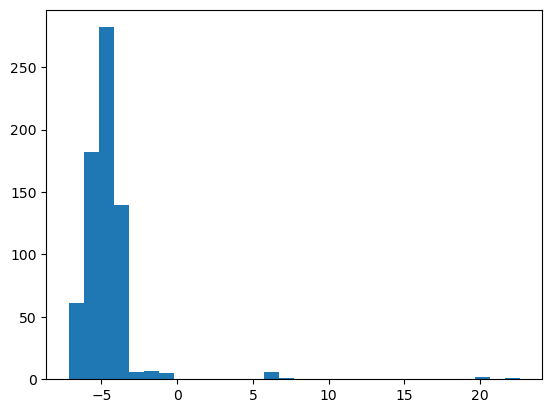

In [39]:
plt.hist(predicted_log_leakage_rates.values(), bins = 30)

In [ ]:
for l

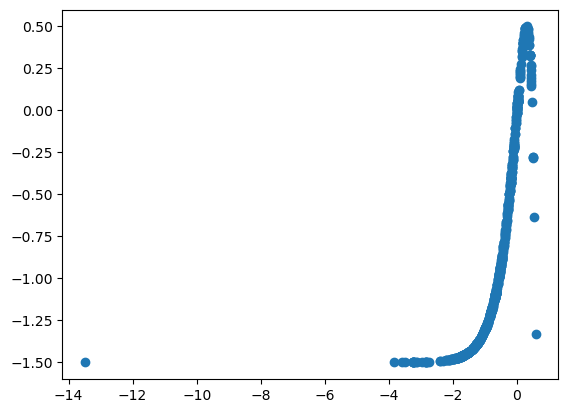

In [20]:
plt.scatter(log_sp, second_order_approx)

In [7]:
solution = cobra.flux_analysis.pfba(model)

In [8]:
turnover_mets = FBA_leak.get_turnover_mets(model, solution)

In [9]:
for m_id in turnover_mets

Index(['10fthf_c', '13dpg_c', '1ddecg3p_c', '1hdec9eg3p_c', '1hdecg3p_c',
       '1pyr5c_c', '23dhdp_c', '23dhmb_c', '23dhmp_c', '25aics_c',
       ...
       'udp_c', 'ugmd_c', 'ugmda_c', 'ump_c', 'uppg3_c', 'utp_c', 'val__L_c',
       'xan_c', 'xmp_c', 'xu5p__D_c'],
      dtype='object', length=337)

In [5]:
leak_solution = FBA_leak.FBA_with_leakage(model)

Index(['10fthf_c', '13dpg_c', '1ddecg3p_c', '1hdec9eg3p_c', '1hdecg3p_c',
       '1pyr5c_c', '23dhdp_c', '23dhmb_c', '23dhmp_c', '25aics_c',
       ...
       'udp_c', 'ugmd_c', 'ugmda_c', 'ump_c', 'uppg3_c', 'utp_c', 'val__L_c',
       'xan_c', 'xmp_c', 'xu5p__D_c'],
      dtype='object', length=339) ['4crsol_c', '5drib_c', 'amob_c', 'mththf_c', 'ac_c', 'ca2_c', 'cl_c', 'co2_c', 'cobalt2_c', 'cu2_c', 'fe2_c', 'glc__D_c', 'h_c', 'h2o_c', 'k_c', 'meoh_c', 'mg2_c', 'mn2_c', 'mobd_c', 'nh4_c', 'ni2_c', 'o2_c', 'pi_c', 'so4_c', 'zn2_c', 'prot_pool']


In [7]:
leak_solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M']

0.6115132510047568

In [9]:
a = model.summary(solution=leak_solution)

In [14]:
model.optimize()
print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6436981589523731

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00335         0   0.00%
      cl_e      EX_cl_e   0.00335         0   0.00%
 cobalt2_e EX_cobalt2_e 1.609E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004564         0   0.00%
     fe2_e     EX_fe2_e   0.01034         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1256         0   0.00%
     mg2_e     EX_mg2_e  0.005584         0   0.00%
     mn2_e     EX_mn2_e 0.0004448         0   0.00%
    mobd_e    EX_mobd_e 8.304E-05         0   0.00%
     nh4_e     EX_nh4_e     6.952         0   0.00%
     ni2_e     EX_ni2_e 0.0002079         0   0.00%
      o2_e      EX_o2_e      17.6         0   0.00%
      pi_e      EX_pi_e    0.6209         0   0.00%
     so4_e     EX_so4_e    0.1623         0   0.00%
     zn2_e     EX_zn2_e 0.0002195  

In [8]:
shadow_prices = leakage.estimate_shadow_prices(model, epsilon = 0.1)

In [9]:
shadow_prices['ala__L_c']

-0.008157997084665691

2dmmq8_c 0.2513914867317373 -1.459310473274184
2dmmql8_c 0.2508142254608499 -1.4572643002983825
athtp_c 0.0 -2.663334043137137
colipa_c 0.7277794893911336 -2.7288698456520377
gagicolipa_c 0.000993940589525219 -2.591396224846886
ggagicolipa_c 0.0004941679229288343 -2.6103075902218347
gggagicolipa_c 0.0 -2.6292133500436004
gicolipa_c 0.0015142490054498858 -2.5724643207566102
hhlipa_c -0.6201467613634597 -2.2750719307757836
hphhlipa_c 0.10087794064408473 -2.381732519235907
icolipa_c 0.0020559046966425742 -2.554310062278361
kphphhlipa_c 0.0 -2.4828879800239783
lipa_cold_c 0.0 -2.1207194448059976
mql8_c -0.0017189015632333472 -1.7150112859585636
mqn8_c 0.0 -1.7154196329749383
phhlipa_c -0.6269454490972091 -2.281799711516342
phphhlipa_c 0.09412919427639777 -2.3884093623393885
q8_c 0.0 -1.6929041021735396
q8h2_c -0.001718901563233349 -1.6944042981037104
uLa4fn_c -0.0015588533761565439 -1.4857163954634534
uLa4n_c 0.0 -1.4843356943920538
uacmamu_c 1.3413395188930453 -0.3684614277418974
udpLa4fn

Text(0, 0.5, 'Gurobi predicted Shadow prices')

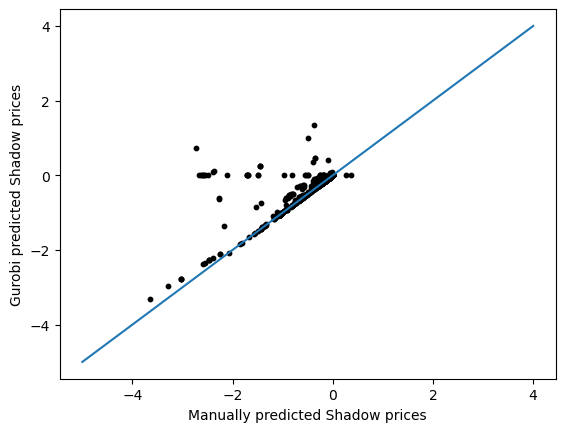

In [10]:
solution = model.optimize()
fig, ax = plt.subplots(1)
for m, sp in shadow_prices.items():
    # print(m, sp2, solution.shadow_prices[m])
    spg = solution.shadow_prices[m]
    ax.scatter(sp, spg, c = 'k', s = 10)
    if abs(sp - spg) > 1:
        # if np.abs((sp2-sp1)/min(abs(sp1), abs(sp2)))> 1:
        # ax.annotate(m[:-2], (sp2+1, sp1))
        print(m, spg, sp)
ax.plot(np.arange(-5, 5), np.arange(-5, 5))
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel('Manually predicted Shadow prices')
plt.ylabel('Gurobi predicted Shadow prices')

In [11]:
solution.shadow_prices

10fthf_c     -0.656662
12dgr120_c   -0.466064
12dgr140_c   -0.524186
12dgr141_c   -0.501553
12dgr160_c   -0.637621
                ...   
xtsn_p       -0.201325
xyl__D_p      0.004468
xylu__L_p    -0.008956
zn2_p        -0.000137
prot_pool    -5.929755
Name: shadow_prices, Length: 1806, dtype: float64

# FBA with leakage


## Define parameters

## Run standard FBA

In [32]:
solution = model.optimize()
print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6436981589523757

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00335         0   0.00%
      cl_e      EX_cl_e   0.00335         0   0.00%
 cobalt2_e EX_cobalt2_e 1.609E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004564         0   0.00%
     fe2_e     EX_fe2_e   0.01034         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1256         0   0.00%
     mg2_e     EX_mg2_e  0.005584         0   0.00%
     mn2_e     EX_mn2_e 0.0004448         0   0.00%
    mobd_e    EX_mobd_e 8.304E-05         0   0.00%
     nh4_e     EX_nh4_e     6.952         0   0.00%
     ni2_e     EX_ni2_e 0.0002079         0   0.00%
      o2_e      EX_o2_e      17.6         0   0.00%
      pi_e      EX_pi_e    0.6209         0   0.00%
     so4_e     EX_so4_e    0.1623         0   0.00%
     zn2_e     EX_zn2_e 0.0002195  

In [33]:
# model.metabolites.q8_c.summary()
# with model:
#     m = model.metabolites.q8_c
#     r = model.add_boundary(m, type = 'demand')
#     r.lower_bound = 0.1
#     solution = model.optimize()
#     print(model.summary())
#     print(solution.shadow_prices['q8_c'])
    

## set minimum growth rate to 0.95 of max

In [34]:
# model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = solution.objective_value*0.95
# print(model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.bounds)
# model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0

## Add leakage reactions

In [35]:
# Get index of intracellular metabolites
intracellular_metabolites = [m.id for m in model.metabolites if m.compartment =='c']


In [36]:
# Get stoichiometric matrix and flux array
S_matrix = cobra.util.create_stoichiometric_matrix(model, array_type='DataFrame')
v_array = np.array(solution.fluxes)

In [118]:
# First find 'turnover-metabolites'
non_zero_reactions = solution.fluxes.abs() > 1e-5

In [114]:
non_zero_reactions

DM_4crsol_c           True
DM_5drib_c            True
DM_aacald_c          False
DM_amob_c            False
DM_mththf_c           True
                     ...  
XYLtex_TG_forward    False
XYLtex_TG_reverse    False
Zn2tex_TG_forward     True
Zn2tex_TG_reverse    False
ER_pool_TG_           True
Name: fluxes, Length: 3178, dtype: bool

In [119]:
# Remove non-intracellular metabolites and zero-flux reactions
S_reduced = S_matrix.loc[intracellular_metabolites, non_zero_reactions]

In [120]:
print(S_reduced.shape)

(1040, 441)


In [121]:
# Remove metabolites that have all zero rows in the S_non_zero matrix
nonzero_mets = (S_reduced != 0).any(axis = 1)
nonzero_rxns2 = (S_reduced != 0).any(axis = 0)

In [122]:
S = S_reduced.loc[nonzero_mets, nonzero_rxns2]

In [123]:
S.shape

(397, 418)

# Remove prot pool

In [124]:
S = S.loc[S.index!='prot_pool',:]

# Remove ACP metabolites


In [131]:
S = S.loc[~S.index.str.contains('ACP'), :]

In [132]:
flux_carrying_mets = S.index

In [133]:
rex = ['4crsol_c','5drib_c','amob_c','mththf_c']
for r_id in rex:
    print(r_id, r_id in S.index)

4crsol_c True
5drib_c True
amob_c False
mththf_c True


In [134]:
# List already excreted metabolites
exchanged_mets = []
for r in model.boundary:
    flux = solution.fluxes[r.id]
    if flux != 0:
        exchanged_mets.append(list(r.metabolites.keys())[0].id)
        

In [129]:
exchanged_mets

['4crsol_c',
 '5drib_c',
 'amob_c',
 'mththf_c',
 'ac_e',
 'ca2_e',
 'cl_e',
 'co2_e',
 'cobalt2_e',
 'cu2_e',
 'fe2_e',
 'glc__D_e',
 'h_e',
 'h2o_e',
 'k_e',
 'meoh_e',
 'mg2_e',
 'mn2_e',
 'mobd_e',
 'nh4_e',
 'ni2_e',
 'o2_e',
 'pi_e',
 'so4_e',
 'zn2_e',
 'prot_pool']

# Implementation 2



In [52]:
with model as M2:
    # Predict leakage rate
    leakage_rate = {}
    leakage_slope = -1.38 # From fit
    leakage_scale = np.e**(-7.35683574)
    leakage_cost = {}
    leak_reactions = {}
    # new_metabolites = []
    for i, m_id in enumerate(flux_carrying_mets):
        if m_id in exchanged_mets:
            continue
        # print(i, m_id)
        m = M2.metabolites.get_by_id(m_id)
        # Check if demand reaction exist
        for r in m.reactions:
            if r.boundary:
                print(r)
        try:
            m_e = M2.metabolites.get_by_id(m_id.replace('_c','_e'))
        except KeyError:
            # m_e = cobra.Metabolite(m_id.replace('_c','_e'))
            m_e = m.copy()
            m_e.id = m_id.replace('_c','_e')
            m_e.compartment = 'e'
            M2.add_boundary(m_e, type='exchange')
        else:
            r_ex = model.reactions.get_by_id('EX_{0}'.format(m_e))
            r_ex.upper_bound = 1000

        sp = shadow_prices[m_id]
        if sp > -1e-6:
            # print(m_id, sp)
            continue
        elif np.isnan(sp):
            continue
        else:
            r = cobra.Reaction('LEAK_{0}'.format(m_id))
            r.add_metabolites({m:-1, m_e:1})
            r.bounds = (0, 1000)
            leak_reactions[m_id] = r
            # leak_mets.append(m)
            leakage_rate[m_id] = leakage_scale*np.abs(sp)**leakage_slope
            leakage_cost[m_id] = np.abs(sp)*leakage_rate[m_id]

    delta_growth = solution.objective_value*(1-0.95)
    scale = delta_growth/sum(leakage_cost.values())
    M2.add_reactions(leak_reactions.values())
    for m_id, r0 in leak_reactions.items():
        r = M2.reactions.get_by_id(r0.id)
        lr = leakage_rate[m_id]
        r.lower_bound = scale*lr
        # print(m_id, scale*lr, r)
    # print(r)
    # r.lower_bound = 1
    
    M2.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
    solution2 = M2.optimize()
    print(M2.summary())
    print(solution2.objective_value)
    
    
    

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6299824939724283

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.003279         0   0.00%
      cl_e      EX_cl_e  0.003279         0   0.00%
 cobalt2_e EX_cobalt2_e 1.575E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004467         0   0.00%
     fe2_e     EX_fe2_e    0.4639         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e     0.123         0   0.00%
     mg2_e     EX_mg2_e  0.005465         0   0.00%
     mn2_e     EX_mn2_e 0.0004353         0   0.00%
    mobd_e    EX_mobd_e 8.127E-05         0   0.00%
     nh4_e     EX_nh4_e     7.027         0   0.00%
     ni2_e     EX_ni2_e 0.0002035         0   0.00%
      o2_e      EX_o2_e     18.63         0   0.00%
      pi_e      EX_pi_e     1.103         0   0.00%
     so4_e     EX_so4_e    0.1616         0   0.00%
     zn2_e     EX_zn2_e 0.0002148  

In [50]:
delta_growth

0.032184907947618815

In [49]:
delta_growth = solution.objective_value*(1-0.95)
scale = delta_growth/sum(leakage_cost.values())

0.4744077487350215

In [30]:
for r in model.metabolites.acser_e.reactions:
    print(r.id, r.bounds)

ACSERtex_TG_forward (0.0, 1000.0)
EX_acser_e (0.0, 0.0)
ACSERtex_TG_reverse (0.0, 1000.0)


In [283]:
model.add_reactions(leak_reactions.values())

Ignoring reaction 'LEAK_10fthf_c' since it already exists.
Ignoring reaction 'LEAK_13dpg_c' since it already exists.
Ignoring reaction 'LEAK_1ddecg3p_c' since it already exists.
Ignoring reaction 'LEAK_1hdec9eg3p_c' since it already exists.
Ignoring reaction 'LEAK_1hdecg3p_c' since it already exists.
Ignoring reaction 'LEAK_1pyr5c_c' since it already exists.
Ignoring reaction 'LEAK_23dhdp_c' since it already exists.
Ignoring reaction 'LEAK_23dhmb_c' since it already exists.
Ignoring reaction 'LEAK_23dhmp_c' since it already exists.
Ignoring reaction 'LEAK_25aics_c' since it already exists.
Ignoring reaction 'LEAK_26dap_LL_c' since it already exists.


In [284]:
model.reactions.LEAK_10fthf_c

Reaction identifier,LEAK_10fthf_c
Name,
Memory address,0x7fca41692ee0
Stoichiometry,10fthf_c --> 10fthf_e 10-Formyltetrahydrofolate --> 10-Formyltetrahydrofolate
GPR,
Lower bound,0.009657670567685996
Upper bound,1000


In [285]:
for m_id, r0 in leak_reactions.items():
    r = model.reactions.get_by_id(r0.id)
    lr = leakage_rate[m_id]
    r.lower_bound = scale*lr
    print(m_id, scale*lr, r)


10fthf_c 0.0028042847245541556 LEAK_10fthf_c: 10fthf_c --> 10fthf_e
13dpg_c 0.018598979556040653 LEAK_13dpg_c: 13dpg_c --> 13dpg_e
1ddecg3p_c 0.004614897371267048 LEAK_1ddecg3p_c: 1ddecg3p_c --> 1ddecg3p_e
1hdec9eg3p_c 0.004239739256961746 LEAK_1hdec9eg3p_c: 1hdec9eg3p_c --> 1hdec9eg3p_e
1hdecg3p_c 0.003948916413249949 LEAK_1hdecg3p_c: 1hdecg3p_c --> 1hdecg3p_e
1pyr5c_c 0.01392670868114295 LEAK_1pyr5c_c: 1pyr5c_c --> 1pyr5c_e
23dhdp_c 0.012088348467733117 LEAK_23dhdp_c: 23dhdp_c --> 23dhdp_e
23dhmb_c 0.008290662279444106 LEAK_23dhmb_c: 23dhmb_c --> 23dhmb_e
23dhmp_c 0.008078527419470256 LEAK_23dhmp_c: 23dhmp_c --> 23dhmp_e
25aics_c 0.005065327869626255 LEAK_25aics_c: 25aics_c --> 25aics_e
26dap_LL_c 0.010284338954929976 LEAK_26dap_LL_c: 26dap_LL_c --> 26dap_LL_e
26dap__M_c 0.010202007074011513 LEAK_26dap__M_c: 26dap__M_c --> 26dap__M_e
2ahbut_c 0.010709085327625814 LEAK_2ahbut_c: 2ahbut_c --> 2ahbut_e
2cpr5p_c 0.005473955970806087 LEAK_2cpr5p_c: 2cpr5p_c --> 2cpr5p_e
2dda7p_c 0.0138262

In [286]:
model.reactions.EX_10fthf_e.lower_bound = leakage_rate['10fthf_c']*scale

In [287]:
leakage_rate['10fthf_c']

1.2340391637257282

In [288]:
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1

In [289]:
model.optimize()

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


<Solution infeasible at 0x7fca59232f10>

In [271]:
model.reactions.LEAK_13dpg_c.bounds

(0, 1000)

# Implementation 1 - seems to not working when the number of leakage-reactions increases above 20 ish
## Now actually add these reactions

In [99]:
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

In [100]:
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

In [101]:
model.reactions.EX_glc__D_e.lower_bound = -10


In [140]:
model.objective.variables

TypeError: 'set' object is not callable

In [102]:
solution = model.optimize()
print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6436981589523757

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00335         0   0.00%
      cl_e      EX_cl_e   0.00335         0   0.00%
 cobalt2_e EX_cobalt2_e 1.609E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004564         0   0.00%
     fe2_e     EX_fe2_e   0.01034         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1256         0   0.00%
     mg2_e     EX_mg2_e  0.005584         0   0.00%
     mn2_e     EX_mn2_e 0.0004448         0   0.00%
    mobd_e    EX_mobd_e 8.304E-05         0   0.00%
     nh4_e     EX_nh4_e     6.952         0   0.00%
     ni2_e     EX_ni2_e 0.0002079         0   0.00%
      o2_e      EX_o2_e      17.6         0   0.00%
      pi_e      EX_pi_e    0.6209         0   0.00%
     so4_e     EX_so4_e    0.1623         0   0.00%
     zn2_e     EX_zn2_e 0.0002195  

In [135]:
with model as M:
    scale = M.problem.Variable('leakage_scale')
    M.add_cons_vars([scale])
    
    leak_reactions = []
    leak_mets = []
    for i, m_id in enumerate(flux_carrying_mets):
        if m_id in exchanged_mets:
            continue
            
        sp = shadow_prices[m_id]
        if (sp > -1e-6) or np.isnan(sp):
            # print(m_id, sp)
            continue
        m = M.metabolites.get_by_id(m_id)
        # Check if demand reaction exist
        for r in m.reactions:
            if r.boundary:
                print(r)
        # Add excahnge
        try:
            m_e = M.metabolites.get_by_id(m_id.replace('_c','_e'))
        except KeyError:
            # m_e = cobra.Metabolite(m_id.replace('_c','_e'))
            m_e = m.copy()
            m_e.id = m_id.replace('_c','_e')
            m_e.compartment = 'e'
            M.add_boundary(m_e, type='exchange')
        else:
            r_ex = model.reactions.get_by_id('EX_{0}'.format(m_e))
            r_ex.upper_bound = 1000
            
        # Add leak reaction
        r = cobra.Reaction('LEAK_{0}'.format(m_id))
        r.add_metabolites({m:-1, m_e:1})
        r.bounds = (0, 1000)
        leak_reactions.append(r)
        leak_mets.append(m)
        # if i > 90:
        #     break
    M.add_reactions(leak_reactions)
    constraints = []
    for m, r in zip(leak_mets, leak_reactions):
        sp = shadow_prices[m.id]
        leakage = np.abs(sp)**(-1.38)
        constraint = M.problem.Constraint(
            r.flux_expression - scale*leakage,
            lb=0,
            ub=100)
        constraints.append(constraint)
        # print(m, r, sp)
        
    M.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
    M.reactions.BIOMASS_Ec_iJO1366_core_53p95M.lower_bound = solution.objective_value*0.95
    M.add_cons_vars(constraints)
    obj = M.problem.Objective(M.solver.variables.leakage_scale, direction = 'max')
    M.objective = obj

    new_solution = M.optimize(objective_sense=None)
    print(M.summary())
    print(new_solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M'])

Non-linear or non-reaction model objective. Falling back to minimal display.


Objective
nan Expression = nan

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.003183         0   0.00%
      cl_e      EX_cl_e  0.003183         0   0.00%
 cobalt2_e EX_cobalt2_e 1.529E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004981         0   0.00%
     fe2_e     EX_fe2_e    0.6587         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1194         0   0.00%
     mg2_e     EX_mg2_e  0.005305         0   0.00%
     mn2_e     EX_mn2_e 0.0004226         0   0.00%
    mobd_e    EX_mobd_e 7.889E-05         0   0.00%
     nh4_e     EX_nh4_e     6.985         0   0.00%
     ni2_e     EX_ni2_e 0.0001975         0   0.00%
      o2_e      EX_o2_e     19.01         0   0.00%
      pi_e      EX_pi_e     1.368         0   0.00%
     so4_e     EX_so4_e    0.1592         0   0.00%
     zn2_e     EX_zn2_e 0.0002085         0   0.00%

Secretion
-------

In [141]:
new_solution.fluxes.to_csv('new_fluxes.csv')

# Get shadow prices

## And add constraints

In [142]:
    #slope = model.problem.Variable('leakage_slope')

In [143]:
    new_solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M']

0.6115132510047568

In [144]:
print(model.summary())

Non-linear or non-reaction model objective. Falling back to minimal display.


Objective
nan Expression = nan

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.003183         0   0.00%
      cl_e      EX_cl_e  0.003183         0   0.00%
 cobalt2_e EX_cobalt2_e 1.529E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004336         0   0.00%
     fe2_e     EX_fe2_e  0.009822         0   0.00%
  glc__D_e  EX_glc__D_e     9.904         6 100.00%
       k_e       EX_k_e    0.1194         0   0.00%
     mg2_e     EX_mg2_e  0.005305         0   0.00%
     mn2_e     EX_mn2_e 0.0004226         0   0.00%
    mobd_e    EX_mobd_e 7.889E-05         0   0.00%
     nh4_e     EX_nh4_e     6.605         0   0.00%
     ni2_e     EX_ni2_e 0.0001975         0   0.00%
      o2_e      EX_o2_e     12.92         0   0.00%
      pi_e      EX_pi_e    0.5899         0   0.00%
     so4_e     EX_so4_e    0.1542         0   0.00%
     zn2_e     EX_zn2_e 0.0002085         0   0.00%

Secretion
-------